## Overview

This notebook shows an end-to-end example of training a TensorFlow model using Keras and Python, then export it to TensorFlow and TensorFlow Lite format. Here we will train a Apple-Tangerine classifier using custom photos dataset.


## Mounting Google Drive


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!ls -la "/content/gdrive/My Drive"

total 15430
-rw------- 1 root root 14443144 May  5 01:05  advanced_digits_model.h5
drwx------ 2 root root     4096 Nov 27 20:04  blog
drwx------ 2 root root     4096 Mar 23 10:18  Book
drwx------ 2 root root     4096 Feb 14  2018  code
drwx------ 2 root root     4096 Apr 18 20:35 'Colab Notebooks'
-rw------- 1 root root     5600 May  5 05:26  cor_7att1204.csv
-rw------- 1 root root    22042 May  5 20:17  Cor_pre1204-7att.ipynb
drwx------ 2 root root     4096 Apr 18 20:14  darknet
-rw------- 1 root root    46718 Dec 21 03:28  digits_357.jpg
-rw------- 1 root root  1248504 Jan 19 17:41  digits_model.h5
drwx------ 2 root root     4096 Feb 14  2018  icon
drwx------ 2 root root     4096 Feb 14  2018  img
drwx------ 2 root root     4096 Feb 15  2018  intro


## Enabling the Tensorflow with GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [0]:
!pip install tensorflow-gpu

     |████████████████████████████████| 421.8MB 25kB/s 
     |████████████████████████████████| 450kB 49.2MB/s 
     |████████████████████████████████| 3.9MB 61.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=3d61abc022eefbd4fa8bb6607b35c234d868d9d107c2829495f5bc2ae1151905
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.2.0rc3 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorboard<2.3.0,>=2.2.0, but you'll have tensorboard 2.1.1 which is incompatible.
ERROR: tensorflow 2.2.0rc3 has requirement tensorflow-estimator<2.3.0,>=2.2.0rc0, but you'll have tensorflow-estimator 2.1.0 which is incompatible.
ERROR: tensorflow-probability 0.10.0rc0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstall

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
print(tf.__version__)

Found GPU at: /device:GPU:0
2.2.0-rc4


## Setup

In [0]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import math
import os
import cv2

# Define Constants
batch_size = 128
num_classes = 0
epochs = 200
CW = 32
CH = 32
CD = 3
model_name = 'apple_custom.h5'
tflite_model_name = 'apple_custom.tflite'
COLAB_DARKNET_PATH = '/content/gdrive/My Drive/darknet'
YOLO_IMAGE_PATH = COLAB_DARKNET_PATH + '/images/'
YOLO_FORMAT_PATH = COLAB_DARKNET_PATH + '/images/'
classes = []

train_images = []
train_labels = []
test_images = []
test_labels = [] 

sample_test_image = 'sample_test.jpg'
sample_test_label = 0

In [0]:
# Helper function to display digit images
def show_sample(images, labels, sample_count=25):
  # Create a square with can fit {sample_count} images
  grid_count = math.ceil(math.ceil(math.sqrt(sample_count)))
  grid_count = min(grid_count, len(images), len(labels))
  
  plt.figure(figsize=(2*grid_count, 2*grid_count))
  for i in range(sample_count):
    plt.subplot(grid_count, grid_count, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.xlabel(labels[i])
  plt.show()

# Download a file if you're using Colab,
def download(path):
  try:
    from google.colab import files
    files.download(path)
  except ImportError:
    import os
    print('Error download:', os.path.join(os.getcwd(), path))

# Get photo ROI cordinates from YOLO format
def getROI(size, box):
    width_ratio = size[1]
    height_ratio = size[0]
    x = float(box[1]) * width_ratio
    y = float(box[2]) * height_ratio
    w = float(box[3]) * width_ratio
    h = float(box[4]) * height_ratio
    half_width = w/2.0
    half_height = h/2.0
    startX = int(x-half_width)
    startY = int(y-half_height)
    endX = int(x+half_width)
    endY = int(y+half_height)
    return (startY, endY, startX, endX)

def imShow(path):
    fig = plt.gcf()
    #fig.set_size_inches(18, 10)
    plt.axis("off")
    plt.imshow(cv2.cvtColor(path, cv2.COLOR_BGR2RGB))
    plt.show()

In [7]:
with open(YOLO_FORMAT_PATH + 'classes.txt', 'r') as txt:
    for line in txt:
        name = line.replace("\n", "")
        classes.append(name)
        num_classes += 1
    print (classes, num_classes)

['apple', 'damaged_apple'] 2


In [8]:
image_count = 0
with open(YOLO_FORMAT_PATH + 'train.txt', 'r') as txt:
    for line in txt:
        file_image_count = 0
        image_path = line.replace("\n", "")
        img = cv2.imread(image_path)
        size = img.shape[:2]
        text_path = image_path[:-4] + '.txt'
        with open(text_path, 'r') as txt:
            for line in txt:
                box = line.split()
                (startY, endY, startX, endX) = getROI(size, box)
                image = cv2.resize(img[startY:endY, startX:endX], (CW,CH), interpolation = cv2.INTER_AREA)
                #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                #image = cv2.equalizeHist(image)
                #imShow(image)
                #print(int(box[0]))
                # update the list of data and labels, respectively
                train_images.append(image)
                train_labels.append(int(box[0])) 
                image_count += 1
                file_image_count += 1
        print ('%s : %d images added' % (image_path, file_image_count))           
# convert the data and labels to NumPy arrays
train_images = np.array(train_images)
train_labels = np.array(train_labels) 
# scale data to the range of [0, 1]
train_images = train_images.astype("float32") / 255.0
# one-hot encode the training and testing labels
train_labels = keras.utils.to_categorical(train_labels, num_classes)
print ('%d images added' % image_count)

/content/gdrive/My Drive/darknet/images/damaged_apple (50).jpg : 6 images added
/content/gdrive/My Drive/darknet/images/apple (290).jpg : 1 images added
/content/gdrive/My Drive/darknet/images/apple (67).jpg : 11 images added
/content/gdrive/My Drive/darknet/images/apple (88).jpg : 10 images added
/content/gdrive/My Drive/darknet/images/damaged_apple (191).jpg : 4 images added
/content/gdrive/My Drive/darknet/images/apple (156).jpg : 17 images added
/content/gdrive/My Drive/darknet/images/apple (228).jpg : 1 images added
/content/gdrive/My Drive/darknet/images/damaged_apple (200).jpg : 3 images added
/content/gdrive/My Drive/darknet/images/damaged_apple (129).jpg : 1 images added
/content/gdrive/My Drive/darknet/images/apple (30).jpg : 9 images added
/content/gdrive/My Drive/darknet/images/apple (101).jpg : 6 images added
/content/gdrive/My Drive/darknet/images/damaged_apple (93).jpg : 3 images added
/content/gdrive/My Drive/darknet/images/apple (253).jpg : 2 images added
/content/gdri

In [11]:
image_count = 0
with open(YOLO_FORMAT_PATH + 'test.txt', 'r') as txt:
    for line in txt:
      file_image_count = 0
      image_path = line.replace("\n", "")
      img = cv2.imread(image_path)
      size = img.shape[:2]
      text_path = image_path[:-4] + '.txt'
      with open(text_path, 'r') as txt:
          for line in txt:
              box = line.split()
              (startY, endY, startX, endX) = getROI(size, box)
              image = cv2.resize(img[startY:endY, startX:endX], (CW,CH), interpolation = cv2.INTER_AREA)
              #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
              #image = cv2.equalizeHist(image)
              #imShow(image)
              # update the list of data and labels, respectively
              test_images.append(image)
              test_labels.append(int(box[0]))
              # save the last one for a test
              cv2.imwrite(sample_test_image, image)  
              sample_test_label = int(box[0]) 
              image_count += 1 
              file_image_count += 1
      print ('%s : %d images added' % (image_path, file_image_count))           
# convert the data and labels to NumPy arrays
test_images = np.array(test_images)
test_labels = np.array(test_labels) 
# scale data to the range of [0, 1]
test_images = test_images.astype("float32") / 255.0
# one-hot encode the training and testing labels
test_labels = keras.utils.to_categorical(test_labels, num_classes)
print ('%d images added' % image_count)

/content/gdrive/My Drive/darknet/images/apple (182).jpg : 1 images added
/content/gdrive/My Drive/darknet/images/damaged_apple (145).jpg : 2 images added
/content/gdrive/My Drive/darknet/images/apple (244).jpg : 1 images added
/content/gdrive/My Drive/darknet/images/damaged_apple (84).jpg : 1 images added
/content/gdrive/My Drive/darknet/images/damaged_apple (112).jpg : 3 images added
/content/gdrive/My Drive/darknet/images/apple (213).jpg : 12 images added
/content/gdrive/My Drive/darknet/images/damaged_apple (104).jpg : 4 images added
/content/gdrive/My Drive/darknet/images/apple (205).jpg : 1 images added
/content/gdrive/My Drive/darknet/images/damaged_apple (153).jpg : 3 images added
/content/gdrive/My Drive/darknet/images/damaged_apple (2).jpg : 1 images added
/content/gdrive/My Drive/darknet/images/apple (194).jpg : 13 images added
/content/gdrive/My Drive/darknet/images/damaged_apple (92).jpg : 1 images added
/content/gdrive/My Drive/darknet/images/apple (252).jpg : 3 images add

Tatal number of Images : 1840


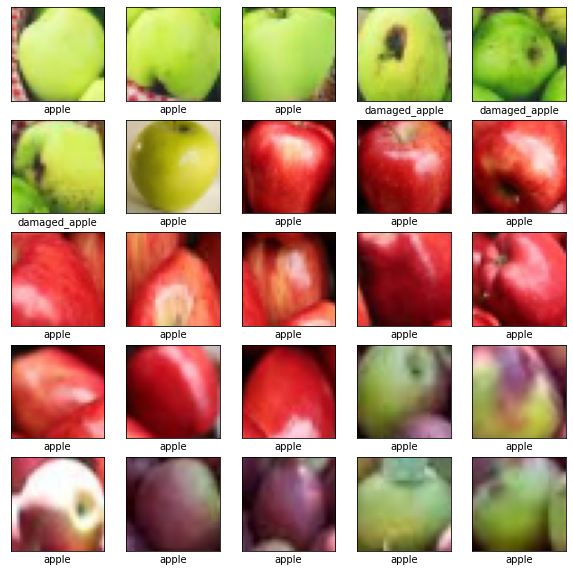

In [12]:
# Show images in the training dataset.
show_number = len(train_images)
print('Tatal number of Images : %d' % show_number)
if (show_number > 25 ):
  show_number = 25
show_sample(train_images, 
            ['%s' % classes[np.argmax(label)] for label in train_labels], show_number)

## Train a TensorFlow model to classify digit images
We use Keras API to build a TensorFlow model that can classify the digit images. Please see this [tutorial](https://www.tensorflow.org/beta/tutorials/keras/basic_classification) if you are interested to learn more about how to build machine learning model with Keras and TensorFlow.

In [0]:
# Define the model architecture
inputShape = (CH, CW, CD)

model = keras.Sequential([
    keras.layers.Flatten(input_shape=inputShape),

    # keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Reshape(target_shape=inputShape),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation=tf.nn.relu),
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    keras.layers.Dropout(0.25),
    keras.layers.Flatten(input_shape=(28, 28)),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),

		# softmax classifier
		keras.layers.Dense(num_classes, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [0]:
# Save the best model as digits_model.h5
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(model_name, save_best_only=True)

# Define a callback to monitor val_loss
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                       patience=5)

In [21]:
# Train the model using the early stopping callback
history = model.fit(train_images, train_labels, 
                    validation_data=(test_images, test_labels),
                    epochs=epochs, batch_size=batch_size,
                    callbacks=[modelCheckpoint])

Epoch 1/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0167 - accuracy: 0.9940 - val_loss: 1.0667 - val_accuracy: 0.8320
Epoch 2/200
15/15 [==============================] - 0s 15ms/step - loss: 0.0112 - accuracy: 0.9946 - val_loss: 1.0580 - val_accuracy: 0.8450
Epoch 3/200
15/15 [==============================] - 0s 16ms/step - loss: 0.0106 - accuracy: 0.9984 - val_loss: 1.0588 - val_accuracy: 0.8501
Epoch 4/200
15/15 [==============================] - 0s 15ms/step - loss: 0.0074 - accuracy: 0.9978 - val_loss: 1.1087 - val_accuracy: 0.8553
Epoch 5/200
15/15 [==============================] - 0s 15ms/step - loss: 0.0049 - accuracy: 0.9989 - val_loss: 1.1207 - val_accuracy: 0.8605
Epoch 6/200
15/15 [==============================] - 0s 15ms/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 1.1650 - val_accuracy: 0.8630
Epoch 7/200
15/15 [==============================] - 0s 15ms/step - loss: 0.0040 - accuracy: 0.9995 - val_loss: 1.2192 - val_accuracy: 0.8708
Epoch 

In [0]:
# Download the digit classification model if you're using Colab, 
download(model_name)

## Evaluate our model
We run our digit classification model against our test dataset that the model hasn't seen during its training process. We want to confirm that the model didn't just remember the digits it saw but also generalize well to new images.

13/13 [==============================] - 0s 3ms/step - loss: 1.5466 - accuracy: 0.8786
Test accuracy: 0.8785529732704163


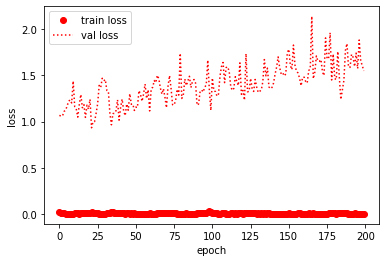

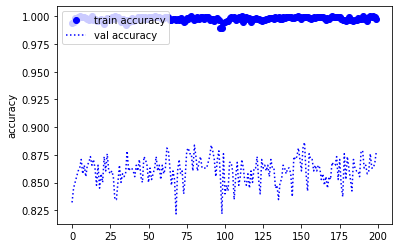

In [22]:
# Evaluate the model using test dataset.
test_loss, test_acc = model.evaluate(test_images, test_labels)

print('Test accuracy:', test_acc)

fig, loss_ax = plt.subplots()
fig, acc_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'ro', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r:', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'bo', label='train accuracy')
acc_ax.plot(history.history['val_accuracy'], 'b:', label='val accuracy')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

Tatal number of Images : 387


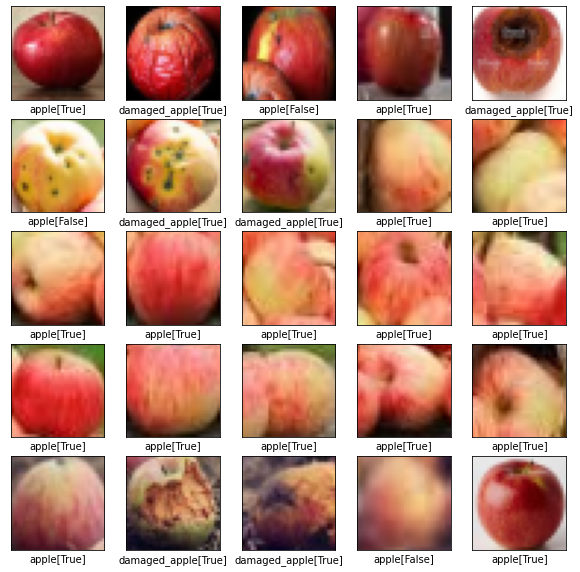

In [25]:
# Predict the labels of digit images in our test dataset.
predictions = model.predict(test_images)
# Then plot the first 25 test images and their predicted labels.
show_number = len(test_images)
print('Tatal number of Images : %d' % show_number)
if (show_number > 25 ):
  show_number = 25
show_sample(test_images, 
            ['%s[%s]' % (classes[np.argmax(result)], np.argmax(result)==np.argmax(test_labels[idx])) 
            for idx, result in enumerate(predictions)], 
            show_number)

damaged_apple : 87.95 [damaged_apple]


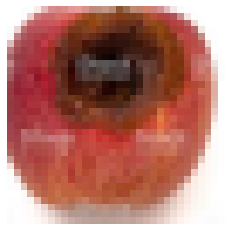

In [26]:
# Predict Model
selected_digit = 4

result = predictions[selected_digit]
result_number = np.argmax(result)
label = test_labels[selected_digit]
label_number = np.argmax(label)
print('%s : %.2f [%s]' % (classes[result_number], result[result_number]*100, classes[label_number]))

imShow(test_images[selected_digit])